In [35]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns


# Simula líneas suaves entre puntos para visualización
from scipy.interpolate import interp1d

## mTAN model

In [2]:
class TimeEmbedding(nn.Module):
    def __init__(self, time_dim):
        super().__init__()
        self.linear = nn.Linear(1, time_dim)

    def forward(self, t):
        # t: [B, L, 1]
        sin_emb = torch.sin(t)
        cos_emb = torch.cos(t)
        linear_emb = self.linear(t)
        return torch.cat([linear_emb, sin_emb, cos_emb], dim=-1)  # [B, L, time_dim + 2]

class MultiTimeAttention(nn.Module):
    def __init__(self, input_dim, time_dim, embed_dim, n_heads=1):
        super().__init__()
        self.time_embedding = TimeEmbedding(time_dim)
        self.q_proj = nn.Linear(time_dim + 2, embed_dim)
        self.k_proj = nn.Linear(time_dim + 2, embed_dim)
        self.v_proj = nn.Linear(input_dim, embed_dim)
        self.n_heads = n_heads
        self.embed_dim = embed_dim

    def forward(self, x, t, r):
        phi_t = self.time_embedding(t)  # [B, L, D_t]
        phi_r = self.time_embedding(r)  # [B, R, D_t]

        Q = self.q_proj(phi_r)
        K = self.k_proj(phi_t)
        V = self.v_proj(x)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.embed_dim ** 0.5
        attn_weights = F.softmax(scores, dim=-1)
        h_r = torch.matmul(attn_weights, V)
        return h_r, attn_weights, scores


In [3]:
class Decoder(nn.Module):
    def __init__(self, embed_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(embed_dim, output_dim)

    def forward(self, h_r):
        return self.linear(h_r)

### Example

In [4]:
# Semilla para reproducibilidad
np.random.seed(42)

# Simular tiempos irregulares
t1 = np.sort(np.random.uniform(0, 3, size=25))
t2 = np.sort(np.random.uniform(0, 3, size=20))

# Simular valores observados (patrón + ruido)
x1 = np.sin(2 * np.pi * t1 / 3) + 0.1 * np.random.randn(len(t1))       # temperatura
x2 = np.cos(2 * np.pi * t2 / 3 + 1.5) + 0.1 * np.random.randn(len(t2)) # humedad

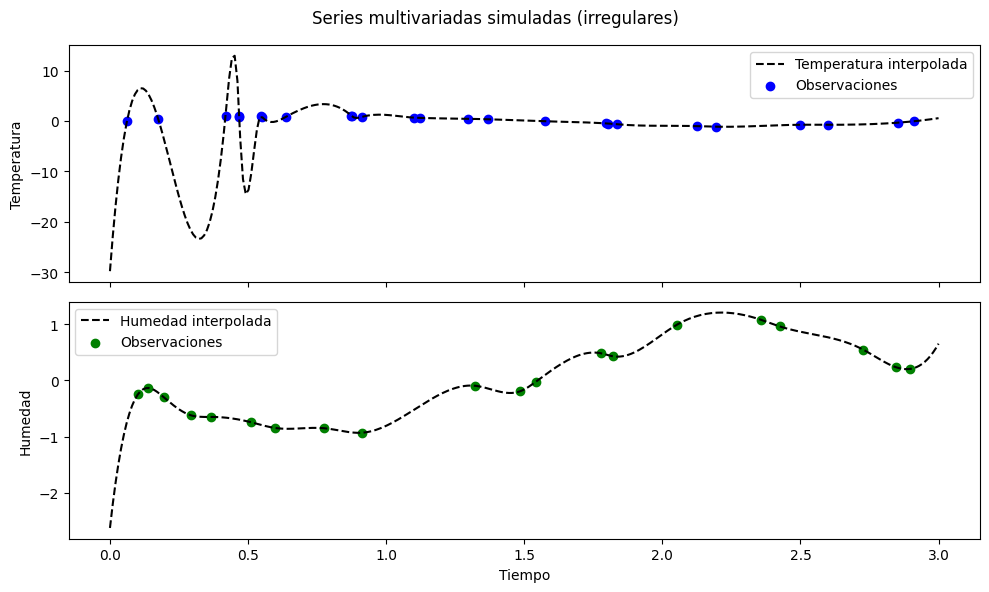

In [5]:
# Interpolación para visualización
t_dense = np.linspace(0, 3, 300)
f1 = interp1d(t1, x1, kind='cubic', fill_value='extrapolate')
f2 = interp1d(t2, x2, kind='cubic', fill_value='extrapolate')

# Graficar
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(t_dense, f1(t_dense), 'k--', label='Temperatura interpolada')
axes[0].scatter(t1, x1, color='blue', label='Observaciones')
axes[0].set_ylabel('Temperatura')
axes[0].legend()

axes[1].plot(t_dense, f2(t_dense), 'k--', label='Humedad interpolada')
axes[1].scatter(t2, x2, color='green', label='Observaciones')
axes[1].set_ylabel('Humedad')
axes[1].set_xlabel('Tiempo')
axes[1].legend()

plt.suptitle("Series multivariadas simuladas (irregulares)")
plt.tight_layout()
plt.show()

In [6]:
# Unificar tiempos
t_all = torch.tensor(sorted(set(t1.tolist() + t2.tolist()))).float()
L = len(t_all)

# Inicializar x con NaNs
x_all = torch.full((L, 2), float('nan'))

# Asignar observaciones
for i, t_val in enumerate(t_all):
    if t_val.item() in t1:
        x_all[i, 0] = torch.tensor(x1[np.where(t1 == t_val.item())[0][0]])
    if t_val.item() in t2:
        x_all[i, 1] = torch.tensor(x2[np.where(t2 == t_val.item())[0][0]])

# Batch de tamaño 1
x = x_all.unsqueeze(0)        # [1, L, 2]
t = t_all.view(1, -1, 1)      # [1, L, 1]

# Máscara de observaciones
mask = ~torch.isnan(x)
x = torch.nan_to_num(x, nan=0.0)

In [7]:
# Hiperparámetros
input_dim = 2
time_dim = 16
embed_dim = 32

encoder = MultiTimeAttention(input_dim, time_dim, embed_dim)
decoder = Decoder(embed_dim, input_dim)

# Tiempo de referencia regular
r_ref = torch.linspace(0, 3, 100).view(1, -1, 1)

# Crear objetivos (targets) en r_ref
r_vals = r_ref[0,:,0]
targets = torch.full((1, len(r_vals), input_dim), float('nan'))

for i, r_i in enumerate(r_vals):
    idx = (t[0,:,0] - r_i).abs().argmin()
    targets[0, i] = x[0, idx]

mask_r = ~torch.isnan(targets)
targets = torch.nan_to_num(targets, nan=0.0)

# Optimizador
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
loss_fn = nn.MSELoss()

# Entrenamiento
for epoch in range(200):
    encoder.train()
    decoder.train()

    h_r, _, _ = encoder(x, t, r_ref)
    x_hat = decoder(h_r)

    loss = loss_fn(x_hat[mask_r], targets[mask_r])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 0.1367
Epoch 20: Loss = 0.0256
Epoch 40: Loss = 0.0013
Epoch 60: Loss = 0.0001
Epoch 80: Loss = 0.0000
Epoch 100: Loss = 0.0000
Epoch 120: Loss = 0.0000
Epoch 140: Loss = 0.0000
Epoch 160: Loss = 0.0000
Epoch 180: Loss = 0.0000


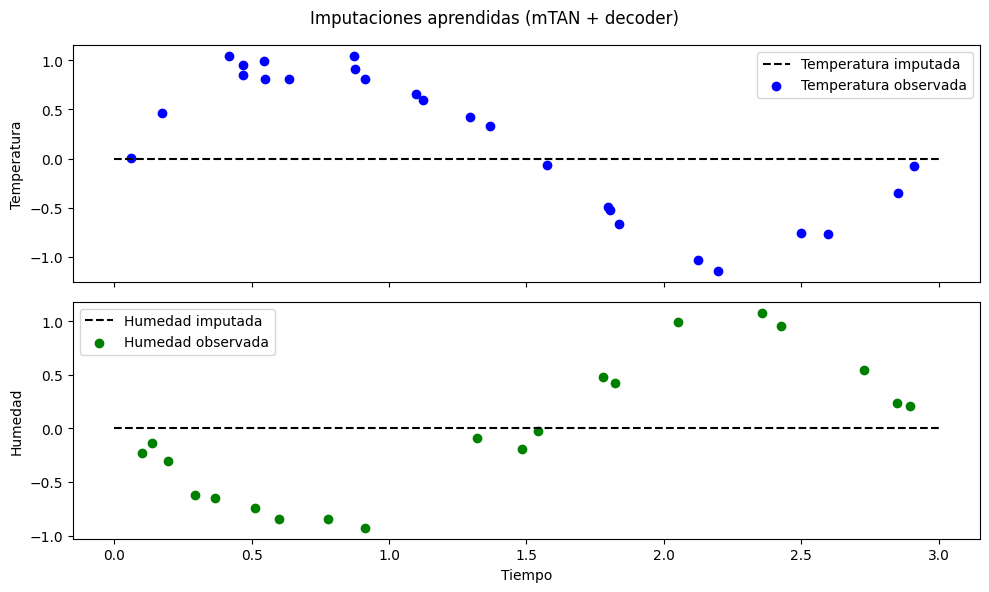

In [8]:
# Evaluación y visualización
encoder.eval()
decoder.eval()

with torch.no_grad():
    h_r, _, _ = encoder(x, t, r_ref)
    x_hat = decoder(h_r)[0].numpy()  # [R, 2]
    r_plot = r_ref[0,:,0].numpy()

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Temperatura
axes[0].plot(r_plot, x_hat[:,0], 'k--', label='Temperatura imputada')
axes[0].scatter(t1, x1, color='blue', label='Temperatura observada')
axes[0].set_ylabel("Temperatura")
axes[0].legend()

# Humedad
axes[1].plot(r_plot, x_hat[:,1], 'k--', label='Humedad imputada')
axes[1].scatter(t2, x2, color='green', label='Humedad observada')
axes[1].set_ylabel("Humedad")
axes[1].set_xlabel("Tiempo")
axes[1].legend()

plt.suptitle("Imputaciones aprendidas (mTAN + decoder)")
plt.tight_layout()
plt.show()

## Forecasting one step ahead (datos de juguete)

In [28]:
torch.manual_seed(0)

# ---------- Serie 1: Temperatura ----------
n1 = 45  # Número de puntos (puedes ajustar entre 20 y 40)
t1_vals = np.sort(np.random.uniform(0.0, 3.0, n1))  # Tiempos irregulares
x1_vals = np.sin(2 * np.pi * t1_vals / 3) + 0.1 * np.random.randn(n1)  # Temperatura

t1 = torch.tensor(t1_vals, dtype=torch.float32).view(1, -1, 1)
x1 = torch.tensor(x1_vals, dtype=torch.float32).view(1, -1, 1)

# ---------- Serie 2: Humedad ----------
n2 = 30  # Número de puntos (puedes ajustar entre 20 y 40)
t2_vals = np.sort(np.random.uniform(0.0, 3.0, n2))  # Tiempos irregulares
x2_vals = 0.5 * np.cos(2 * np.pi * t2_vals / 3) + 0.1 * np.random.randn(n2)  # Humedad

t2 = torch.tensor(t2_vals, dtype=torch.float32).view(1, -1, 1)
x2 = torch.tensor(x2_vals, dtype=torch.float32).view(1, -1, 1)

# ---------- Unir como entrada multivariable ----------
t = torch.cat([t1, t2], dim=1)  # [1, L, 1]
x = torch.cat([x1, x2], dim=1)  # [1, L, 1]

# Ordenar por tiempo
idx_sort = t[0, :, 0].argsort()
t = t[:, idx_sort, :]
x = x[:, idx_sort, :]

# Agregar canal de humedad con ceros por ahora (para predecir ambos canales)
x_pad = torch.cat([x, torch.zeros_like(x)], dim=-1)  # [1, L, 2]
input_dim = x_pad.shape[-1]

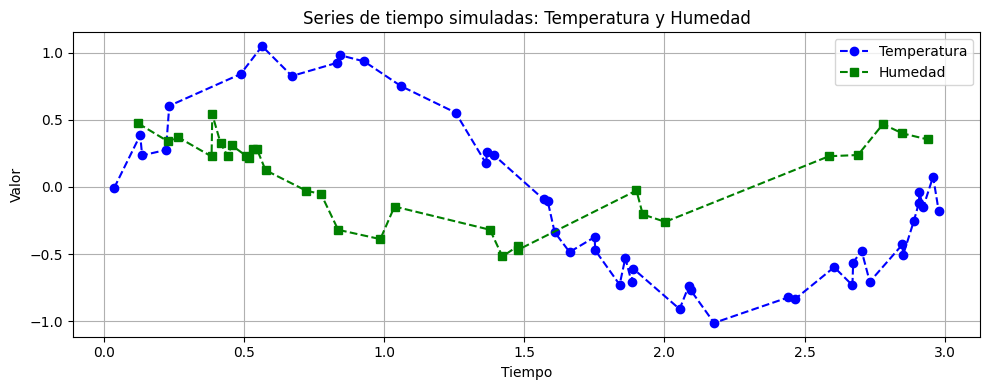

In [29]:
plt.figure(figsize=(10, 4))

# Serie 1: Temperatura (azul)
plt.plot(t1[0].numpy(), x1[0].numpy(), 'o--', color='blue', label='Temperatura')
# Serie 2: Humedad (verde)
plt.plot(t2[0].numpy(), x2[0].numpy(), 's--', color='green', label='Humedad')

plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.title("Series de tiempo simuladas: Temperatura y Humedad")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
time_dim = 16
embed_dim = 32

encoder = MultiTimeAttention(input_dim=2, time_dim=time_dim, embed_dim=embed_dim)
decoder = Decoder(embed_dim=embed_dim, output_dim=2)

In [31]:
# Tiempos de referencia regulares
r_ref = torch.linspace(0.0, 3.0, 60).view(1, -1, 1)

# Tiempo futuro (no observado)
t_futuro = torch.tensor([[[3.2]]], dtype=torch.float32)
r_ext = torch.cat([r_ref, t_futuro], dim=1)  # [1, R+1, 1]

In [32]:
r_vals = r_ref[0,:,0]
targets = torch.full((1, len(r_vals), input_dim), float('nan'))

for i, r_i in enumerate(r_vals):
    idx = (t[0,:,0] - r_i).abs().argmin()
    targets[0, i] = x_pad[0, idx]

mask_r = ~torch.isnan(targets)
targets = torch.nan_to_num(targets, nan=0.0)

# Crear valor objetivo para el futuro
x_futuro_real = torch.tensor([[[np.sin(2 * np.pi * 3.2 / 3), 0.0]]], dtype=torch.float32)  # solo temperatura

In [33]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(300):
    encoder.train()
    decoder.train()

    h_r, _, _ = encoder(x_pad, t, r_ext)       # [1, R+1, D]
    x_hat = decoder(h_r)                       # [1, R+1, 2]

    # Pérdida reconstrucción (en r_ref)
    loss_rec = loss_fn(x_hat[0, :-1][mask_r[0]], targets[0][mask_r[0]])

    # Pérdida de predicción (última posición)
    loss_pred = loss_fn(x_hat[0, -1], x_futuro_real[0, 0])

    loss = loss_rec + loss_pred

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss rec = {loss_rec.item():.4f}, pred = {loss_pred.item():.4f}")

Epoch 0: Loss rec = 0.1822, pred = 0.1689
Epoch 50: Loss rec = 0.1893, pred = 0.0251
Epoch 100: Loss rec = 0.1849, pred = 0.0232
Epoch 150: Loss rec = 0.1650, pred = 0.0107
Epoch 200: Loss rec = 0.1036, pred = 0.0030
Epoch 250: Loss rec = 0.0682, pred = 0.0003


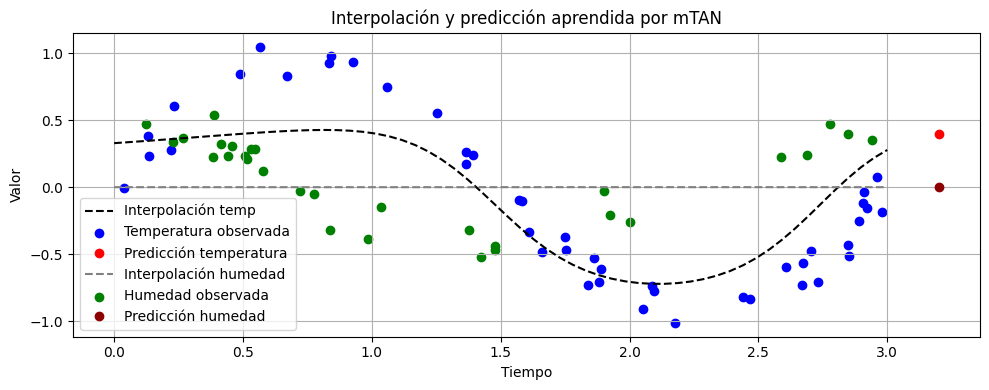

In [34]:
# Convertir a NumPy (detached)
t1_np = t1[0].detach().numpy()
x1_np = x1[0].detach().numpy()
t2_np = t2[0].detach().numpy()
x2_np = x2[0].detach().numpy()

r_plot_np = r_ref[0].detach().numpy()              # [R]
x_hat_np = x_hat[0, :-1].detach().numpy()          # [R, 2]
x_pred_np = x_hat[0, -1].detach().numpy()          # [2]
t_pred_np = t_futuro[0, 0, 0].item()               # Escalar

plt.figure(figsize=(10, 4))

# ---- Temperatura ----
plt.plot(r_plot_np, x_hat_np[:, 0], 'k--', label='Interpolación temp')
plt.scatter(t1_np, x1_np, color='blue', label='Temperatura observada')
plt.plot(t_pred_np, x_pred_np[0], 'ro', label='Predicción temperatura')

# ---- Humedad ----
plt.plot(r_plot_np, x_hat_np[:, 1], 'gray', linestyle='--', label='Interpolación humedad')
plt.scatter(t2_np, x2_np, color='green', label='Humedad observada')
plt.plot(t_pred_np, x_pred_np[1], 'o', color='darkred', label='Predicción humedad')

plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.title("Interpolación y predicción aprendida por mTAN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Evaluación sin gradientes
encoder.eval()
decoder.eval()

with torch.no_grad():
    h_r, attn_weights, scores = encoder(x_pad, t, r_ext)
    x_hat = decoder(h_r)[0].numpy()
    attn_weights_np = attn_weights[0].numpy()  # [R+1, L]
    r_plot = r_ext[0,:,0].numpy()
    t_obs = t[0,:,0].numpy()

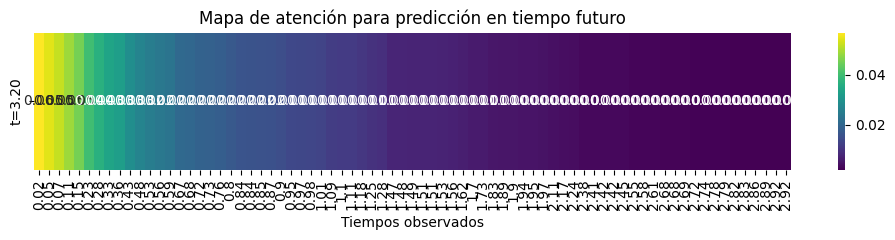

In [18]:
plt.figure(figsize=(10, 2.5))
sns.heatmap(
    attn_weights_np[-1:].clip(1e-5, 1),  # último tiempo (futuro)
    xticklabels=np.round(t_obs, 2),
    yticklabels=[f"t={r_plot[-1]:.2f}"],
    cmap='viridis',
    cbar=True,
    annot=True,
    fmt=".2f"
)
plt.xlabel("Tiempos observados")
plt.title("Mapa de atención para predicción en tiempo futuro")
plt.tight_layout()
plt.show()

In [19]:
# Predicción y valor real
y_pred = x_hat[-1, 0]  # temperatura
y_true = x_futuro_real[0, 0, 0].item()

mae = abs(y_pred - y_true)
rmse = np.sqrt((y_pred - y_true) ** 2)
mape = abs((y_true - y_pred) / y_true) * 100 if y_true != 0 else np.nan

print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")

MAE  = 0.0186
RMSE = 0.0186
MAPE = 4.57%


--------------------------------

## Forecasting one step ahead (datos sintéticos)

In [38]:
# --- Cargar CSVs ---
df_sleep = pd.read_csv("/home/gmartinez/Tesis/Datasets/Synthetic data/simulated_sleep_data.csv")
df_hr = pd.read_csv("/home/gmartinez/Tesis/Datasets/Synthetic data/simulated_heart_rate_data.csv")

In [58]:
# --- Filtrar un solo usuario y una sesión de sueño (puedes automatizar esto) ---
user_id = 1

In [63]:
# --- Asegurar conversión a datetime ---
df_sleep["timestamp"] = pd.to_datetime(df_sleep["timestamp"])
df_hr["timestamp"] = pd.to_datetime(df_hr["timestamp"])

In [64]:
sleep_data = df_sleep[df_sleep["user_id"] == user_id].copy()
sleep_data

,user_id,sleep_id,timestamp,light,rem,deep,fall_asleep,awake,device,is_anomalous
0,1,1_20240101,2024-01-01 21:14:00,NaN,NaN,NaN,NaN,NaN,Source_F,True
1,1,1_20240102,2024-01-02 21:35:00,15886.0,6170.0,5935.0,378.0,2054.0,Source_F,False
2,1,1_20240103,2024-01-03 22:59:00,NaN,NaN,NaN,NaN,NaN,Source_B,True
3,1,1_20240104,2024-01-04 23:58:00,16225.0,7155.0,4799.0,3555.0,1608.0,Source_A,False
4,1,1_20240105,2024-01-05 23:50:00,NaN,NaN,NaN,NaN,NaN,Source_E,True
...,...,...,...,...,...,...,...,...,...,...
15027,1,1_20240218,2024-02-18 21:59:00,NaN,NaN,NaN,NaN,NaN,Source_F,True
15566,1,1_20240206,2024-02-06 22:45:00,17503.0,7083.0,7379.0,-43.0,1852.0,Source_C,False
15660,1,1_20240315,2024-03-15 22:25:00,14892.0,5946.0,5409.0,2751.0,986.0,Source_E,False
15727,1,1_20240101,2024-01-01 21:14:00,NaN,NaN,NaN,NaN,NaN,Source_F,True


In [65]:
hr_data = df_hr[df_hr["user_id"] == user_id].copy()
hr_data

,user_id,sleep_id,timestamp,duration_secs,activity,hr_min,hr_avg,hr_max,device,is_anomalous
0,1,1_20240101,2024-01-01 03:04:00,5236,Swimming,66,76,116,Source_C,False
1,1,1_20240101,2024-01-01 05:10:00,6038,Gym,70,89,90,Source_A,False
2,1,1_20240101,2024-01-01 07:21:00,6348,Walking,69,71,122,Source_E,False
3,1,1_20240101,2024-01-01 11:40:00,1874,Swimming,67,72,123,Source_E,False
4,1,1_20240101,2024-01-01 06:55:00,7037,Cycling,23,41,215,Source_B,True
...,...,...,...,...,...,...,...,...,...,...
95151,1,1_20240218,2024-02-18 12:51:00,3617,Running,55,57,75,Source_F,False
95621,1,1_20240308,2024-03-08 05:32:00,3615,Gym,24,34,212,Source_B,True
95785,1,1_20240306,2024-03-05 23:36:00,1673,Cycling,47,70,78,Source_B,False
95977,1,1_20240311,2024-03-11 12:13:00,3409,Cycling,49,54,122,Source_F,False


In [66]:
# --- Usar el primer timestamp como referencia para normalizar el tiempo ---
ref_time = min(sleep_data["timestamp"].min(), hr_data["timestamp"].min())
ref_time

Timestamp('2024-01-01 01:54:00')

In [67]:
# --- Calcular tiempo relativo en segundos ---
sleep_data["t_secs"] = (sleep_data["timestamp"] - ref_time).dt.total_seconds()
hr_data["t_secs"] = (hr_data["timestamp"] - ref_time).dt.total_seconds()

In [68]:
# --- Normalizar tiempo entre 0 y 1 ---
t_max = max(sleep_data["t_secs"].max(), hr_data["t_secs"].max())
sleep_data["t_norm"] = sleep_data["t_secs"] / t_max
hr_data["t_norm"] = hr_data["t_secs"] / t_max

In [69]:
# --- Variables de interés ---
sleep_vars = ["light", "rem", "deep", "fall_asleep", "awake"]
hr_vars = ["hr_min", "hr_avg", "hr_max"]

In [70]:
# --- Convertir datos a numpy ---
x_sleep = sleep_data[sleep_vars].values.astype(np.float32)
t_sleep = sleep_data["t_norm"].values.reshape(-1, 1).astype(np.float32)

x_hr = hr_data[hr_vars].values.astype(np.float32)
t_hr = hr_data["t_norm"].values.reshape(-1, 1).astype(np.float32)

In [77]:
x_sleep.shape

(112, 5)

In [78]:
x_hr.shape

(702, 3)

In [79]:
# --- Padding para igualar dimensión ---
n_sleep, d_sleep = x_sleep.shape
n_hr, d_hr = x_hr.shape
D_total = d_sleep + d_hr  # = 5 + 3 = 8

# Crear vectores con ceros donde no hay datos
x_sleep_padded = np.concatenate([x_sleep, np.zeros((n_sleep, d_hr))], axis=1)  # [N_sleep, 8]
x_hr_padded = np.concatenate([np.zeros((n_hr, d_sleep)), x_hr], axis=1)        # [N_hr, 8]

# Concatenar ahora sí
x_all = np.concatenate([x_sleep_padded, x_hr_padded], axis=0)  # [N_sleep + N_hr, 8]

In [80]:
# --- Concatenar datos ---
x_all

array([[   nan,    nan,    nan, ...,     0.,     0.,     0.],
       [15886.,  6170.,  5935., ...,     0.,     0.,     0.],
       [   nan,    nan,    nan, ...,     0.,     0.,     0.],
       ...,
       [    0.,     0.,     0., ...,    47.,    70.,    78.],
       [    0.,     0.,     0., ...,    49.,    54.,   122.],
       [    0.,     0.,     0., ...,    60.,    73.,   100.]])

In [82]:
t_all = np.concatenate([t_sleep, t_hr], axis=0)                 # [L, 1]

In [83]:
# Ordenar por tiempo
idx_sort = np.argsort(t_all[:, 0])
x_sorted = x_all[idx_sort]
t_sorted = t_all[idx_sort]

In [84]:
# Convertir a tensores
x_tensor = torch.tensor(x_sorted).unsqueeze(0)  # [1, L, D]
t_tensor = torch.tensor(t_sorted).unsqueeze(0)  # [1, L, 1]

# Crear puntos de referencia regulares
r_ref = torch.linspace(0.0, 1.0, steps=100).view(1, -1, 1)

print("x_tensor shape:", x_tensor.shape)
print("t_tensor shape:", t_tensor.shape)
print("r_ref shape:", r_ref.shape)

x_tensor shape: torch.Size([1, 814, 8])
t_tensor shape: torch.Size([1, 814, 1])
r_ref shape: torch.Size([1, 100, 1])


In [85]:
# Inspección de los primeros elementos
for i in range(5):
    print(f"t = {t_tensor[0, i, 0]:.3f} --> x = {x_tensor[0, i]}")

t = 0.000 --> x = tensor([  0.,   0.,   0.,   0.,   0.,  29.,  36., 202.], dtype=torch.float64)
t = 0.000 --> x = tensor([  0.,   0.,   0.,   0.,   0.,  30.,  36., 206.], dtype=torch.float64)
t = 0.000 --> x = tensor([  0.,   0.,   0.,   0.,   0.,  66.,  76., 116.], dtype=torch.float64)
t = 0.001 --> x = tensor([ 0.,  0.,  0.,  0.,  0., 70., 89., 90.], dtype=torch.float64)
t = 0.002 --> x = tensor([  0.,   0.,   0.,   0.,   0.,  23.,  41., 215.], dtype=torch.float64)


In [86]:
# Tiempo futuro para predecir (extrapolación)
t_futuro = torch.tensor([[[1.05]]], dtype=torch.float32)  # Puede ajustarse
r_ext = torch.cat([r_ref, t_futuro], dim=1)  # [1, R+1, 1]

In [87]:
# Crear targets para reconstrucción sobre r_ref
r_vals = r_ref[0, :, 0]
targets = torch.full((1, len(r_vals), x_tensor.shape[-1]), float('nan'))  # [1, R, D]

for i, r_i in enumerate(r_vals):
    idx = (t_tensor[0, :, 0] - r_i).abs().argmin()  # punto observado más cercano
    targets[0, i] = x_tensor[0, idx]

# Máscara de puntos válidos y reemplazo de NaN por 0.0
mask_r = ~torch.isnan(targets)
targets = torch.nan_to_num(targets, nan=0.0)

In [88]:
# Simular el valor real en t=1.05
# En una aplicación real vendría del siguiente día de sueño o siguiente punto de FC
x_futuro_real = torch.zeros((1, x_tensor.shape[-1]), dtype=torch.float32)

In [90]:
input_dim = x_tensor.shape[-1]
time_dim = 16
embed_dim = 32

encoder = MultiTimeAttention(input_dim=input_dim, time_dim=time_dim, embed_dim=embed_dim)
decoder = Decoder(embed_dim=embed_dim, output_dim=input_dim)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
loss_fn = torch.nn.MSELoss()

In [91]:
# ---------- Asegurar float32 ----------
x_tensor = x_tensor.float()
t_tensor = t_tensor.float()
r_ref = r_ref.float()

# ---------- Referencia extendida para incluir futuro ----------
t_futuro = torch.tensor([[[1.05]]], dtype=torch.float32)
r_ext = torch.cat([r_ref, t_futuro], dim=1).float()  # [1, R+1, 1]

# ---------- Targets para reconstrucción ----------
r_vals = r_ref[0, :, 0]
targets = torch.full((1, len(r_vals), input_dim), float('nan'), dtype=torch.float32)

In [92]:
for i, r_i in enumerate(r_vals):
    idx = (t_tensor[0, :, 0] - r_i).abs().argmin()
    targets[0, i] = x_tensor[0, idx]

mask_r = ~torch.isnan(targets)
targets = torch.nan_to_num(targets, nan=0.0).float()

# ---------- Placeholder para valor futuro ----------
# Si tienes datos reales para t > 1.0, reemplaza esto
x_futuro_real = torch.zeros((1, input_dim), dtype=torch.float32)

In [94]:
# ---------- Entrenamiento ----------
for epoch in range(300):
    encoder.train()
    decoder.train()

    # Forward pass
    h_r, attn_weights, _ = encoder(x_tensor, t_tensor, r_ext)  # [1, R+1, D]
    x_hat = decoder(h_r)                                       # [1, R+1, input_dim]

    # Pérdida de reconstrucción (solo en r_ref, sin futuro)
    x_hat_rec = x_hat[0, :-1]  # [R, D]
    targets_masked = targets[0][mask_r[0]]  # [M, D]
    x_hat_masked = x_hat_rec[mask_r[0]]     # [M, D]
    loss_rec = loss_fn(x_hat_masked, targets_masked)

    # Pérdida de predicción en el futuro (última posición)
    x_hat_pred = x_hat[0, -1]  # [D]
    loss_pred = loss_fn(x_hat_pred, x_futuro_real[0])

    # Total loss
    loss = loss_rec + loss_pred

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Debug
    if epoch % 50 == 0 or epoch == 0:
        print(f"[Epoch {epoch}] Loss rec = {loss_rec.item():.4f}, pred = {loss_pred.item():.4f}")
        if epoch == 0:
            print(f"x_hat shape: {x_hat.shape}")
            print(f"targets shape: {targets.shape}")
            print(f"x_hat dtype: {x_hat.dtype}, targets dtype: {targets.dtype}, x_futuro_real dtype: {x_futuro_real.dtype}")

[Epoch 0] Loss rec = nan, pred = nan
x_hat shape: torch.Size([1, 101, 8])
targets shape: torch.Size([1, 100, 8])
x_hat dtype: torch.float32, targets dtype: torch.float32, x_futuro_real dtype: torch.float32
[Epoch 50] Loss rec = nan, pred = nan
[Epoch 100] Loss rec = nan, pred = nan
[Epoch 150] Loss rec = nan, pred = nan
[Epoch 200] Loss rec = nan, pred = nan
[Epoch 250] Loss rec = nan, pred = nan


--------------------------------

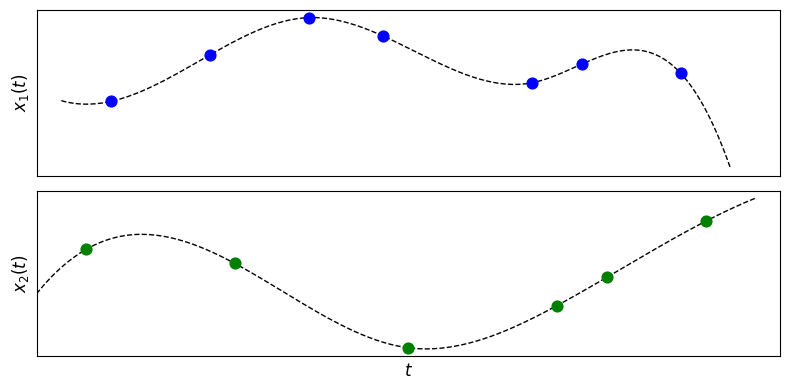

In [49]:
# Datos de entrada simulados
t1 = torch.tensor([0.3, 0.7, 1.1, 1.4, 2.0, 2.2, 2.6]).view(-1).numpy()
x1 = torch.tensor([0.1, 0.6, 1.0, 0.8, 0.3, 0.5, 0.4]).view(-1).numpy()

t2 = torch.tensor([0.2, 0.8, 1.5, 2.1, 2.3, 2.7]).view(-1).numpy()
x2 = torch.tensor([0.5, 0.4, -0.2, 0.1, 0.3, 0.7]).view(-1).numpy()


t1_interp = np.linspace(min(t1)-0.2, max(t1)+0.2, 200)
f1 = interp1d(t1, x1, kind='cubic', fill_value='extrapolate')
x1_interp = f1(t1_interp)

t2_interp = np.linspace(min(t2)-0.2, max(t2)+0.2, 200)
f2 = interp1d(t2, x2, kind='cubic', fill_value='extrapolate')
x2_interp = f2(t2_interp)

# Graficar en subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# Serie 1
axes[0].plot(t1_interp, x1_interp, 'k--', linewidth=1)
axes[0].scatter(t1, x1, color='blue', s=60, zorder=3)
axes[0].set_ylabel(r'$x_1(t)$', fontsize=12)
axes[0].set_xlim(0, 3)
axes[0].grid(False)
axes[0].set_yticks([])
axes[0].set_xticks([])

# Serie 2
axes[1].plot(t2_interp, x2_interp, 'k--', linewidth=1)
axes[1].scatter(t2, x2, color='green', s=60, zorder=3)
axes[1].set_ylabel(r'$x_2(t)$', fontsize=12)
axes[1].set_xlabel(r'$t$', fontsize=12)
axes[1].set_xlim(0, 3)
axes[1].grid(False)
axes[1].set_yticks([])

plt.tight_layout()
plt.show()